In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from torch.utils.data.dataset import Dataset
from torchvision import transforms
import time 
from PIL import Image

In [2]:
def loadModel():
    model = torch.load(os.path.join(os.getcwd(),'cardtop.pt'))
    model.avgpool = nn.AvgPool2d(kernel_size=7,stride=1,padding=0)
    return model
def loadData(imgPATH):
    dfs = pd.read_excel("cardLaberlling.xlsx")
    dfs = dfs.drop(np.arange(2500,5000,1))
    distinctNames = np.unique(np.array(dfs['card name']).astype(str))
    imgArr = np.array(Image.open(imgPATH).convert('RGB'))
    return np.array([imgArr]),distinctNames
class CustomDatasetFrom(Dataset): # input np arrays
    def __init__(self,nparray,nblabels,transform=None):
        self.data = nparray
        self.nlabels = nblabels
        self.transforms = transform
    def __getitem__(self,index):
        img_as_np = self.data[index]
        img_as_img = Image.fromarray(img_as_np)
        if self.transforms is not None:
            img_as_tensor = self.transforms(img_as_img)
        return img_as_tensor
    def __len__(self):
        return self.data.shape[0]
def runmodel(model,dataloaders,device):
    was_training = model.training
    model.eval()
    labs = []; total = 0; correct = 0
    with torch.no_grad():
        for i, (inputs) in enumerate(dataloaders):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                tmp = preds[j].cpu().numpy()
                labs.append(tmp)
    return np.array(labs)
def img2label(imgPATH):
    imgArr,classNames = loadData(imgDIR)
    model = loadModel()
    transformations = transforms.Compose([
        transforms.Resize((224,224)), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    nb_labels = len(classNames)
    custom_data = CustomDatasetFrom(imgArr,nb_labels,transformations)
    dataloaders = torch.utils.data.DataLoader(custom_data, batch_size=1,
                                    shuffle=False, num_workers=0)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    pred = runmodel(model,dataloaders,device)
    return pred,imgArr,classNames

In [4]:
imgDIR = '2935card.png'
# 2928-2935 examples
start = time.time()
pred,imgArr,classNames = img2label(imgDIR)
end = time.time()
print(end-start)

4.136504411697388


Text(0.5, 1.0, '2d')

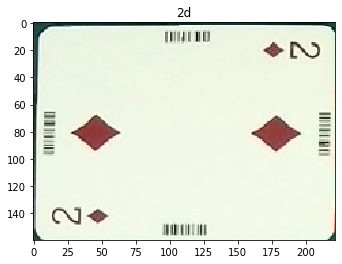

In [5]:
plt.imshow(imgArr[0])
plt.title(classNames[pred[0]])